# Notebook 3ου εργαστηρίου
Πριν προχωρήσετε, εκτελέστε τα επόμενα δύο κελιά.

In [ ]:
val path = System.getProperty("user.dir") + "/source/load-ivy.sc"
interp.load.module(ammonite.ops.Path(java.nio.file.FileSystems.getDefault().getPath(path)))

In [ ]:
import chisel3._
import chisel3.util._
import chisel3.tester._
import chisel3.tester.RawTester.test
import dotvisualizer._

## Περιγραφή συμπεριφοράς κυκλωμάτων
Στην Chisel σπάνια θα χρειαστεί να περιγράψουμε τη συμπεριφορά ενός module στο χαμηλό επίπεδο των λογικών πράξεων με πύλες. Στο εργαστήριο αυτό θα δούμε πώς μπορούμε να περιγράψουμε ένα κύκλωμα μέσα από την αναμενόμενη **συμπεριφορά** του. Όπως και σε όλες τις άλλες περιπτώσεις, η Chisel θα κατασκευάσει μια περιγραφή κυκλώματος, η οποία όταν υλοποιηθεί με κάποια τεχνολογία θα έχει τη ζητούμενη συμπεριφορά.

## Παράδειγμα: ο πολυπλέκτης 4-σε-1
Στο επόμενο κελί εμφανίζεται μια πιθανή υλοποίηση του **πολυπλέκτη 4-σε-1** με πύλες (λογικές πράξεις):

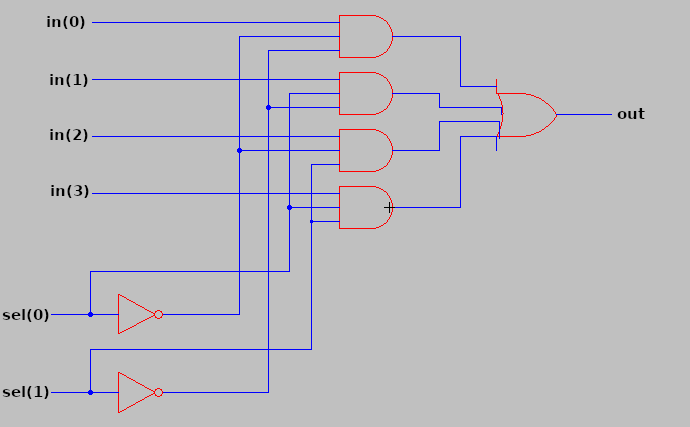

Και ακολουθεί η περιγραφή του πολυπλέκτη 4-σε-1 στην Chisel στο επόμενο κελί (εκτελέστε το):

In [ ]:
class Mux4to1 extends Module {
  val io = IO(new Bundle {
    val in = Input(UInt(4.W))
    val out = Output(UInt(1.W))
    val sel = Input(UInt(2.W))
  })
    
  val p0 = io.in(0) & ~io.sel(0) & ~io.sel(1)
  val p1 = io.in(1) & io.sel(0) & ~io.sel(1)
  val p2 = io.in(2) & ~io.sel(0) & io.sel(1)
  val p3 = io.in(3) & io.sel(0) & io.sel(1)
  io.out := p0 | p1 | p2 | p3
}

Ο έλεγχος ορθότητας εξετάζει για κάθε συνδυασμό του `io.sel` (εξωτερικό for) αν εμφανίζεται στην έξοδο η κατάλληλη είσοδος, για κάθε πιθανή τιμή εισόδου `io.in` (εσωτερικό for). Παρατηρήστε ότι χρησιμοποιούμε την υποκείμενη γλώσσα (Scala) για να αυτοματοποιήσουμε τον έλεγχο. Η μεταβλητή `mask` χρησιμοποιείται για να απομονώνουμε την επιλεγμένη είσοδο `io.in(s)` και να ελέγχουμε αν αυτή η είσοδος ταιριάζει με την έξοδο.

*(εκτελέστε το επόμενο κελί)*

In [ ]:
test(new Mux4to1()) { c =>
  for (s <- 0 to 3) {
    c.io.sel.poke(s.U)
    for (i <- 0 to 15) {
      c.io.in.poke(i.U)
      val mask = 1 << s
      c.io.out.expect(if ((i&mask)!=0) 1.U else 0.U)
    }
  }
}
println("SUCCESS!!")


## Περιγραφή συμπεριφοράς με τη δομή when..elsewhen..otherwise

Ο ίδιος πολυπλέκτης 4-σε-1 με τη δομή `when..elsewhen..otherwise`.

**Παρατηρήστε ότι η ισότητα ελέγχεται με το `===`(τριπλό ίσον)!**

Εκτελέστε το επόμενο κελί που επανακαθορίζει το module `Mux4to1`. Στη συνέχεια τρέξτε το προηγούμενο `test` για να βεβαιωθείτε ότι και αυτή η εκδοχή του πολυπλέκτη δουλεύει κατά το αναμενόμενο. 

In [ ]:
class Mux4to1 extends Module {
  val io = IO(new Bundle {
    val in = Input(UInt(4.W))
    val out = Output(UInt(1.W))
    val sel = Input(UInt(2.W))
  })
  
  when(io.sel===0.U) {
    io.out := io.in(0)
  }.elsewhen (io.sel===1.U) {
    io.out := io.in(1)
  }.elsewhen (io.sel===2.U) {
    io.out := io.in(2)
  }.otherwise {
    io.out := io.in(3)
  }
}

## Περιγραφή συμπεριφοράς με τη δομή switch

Μια δεύτερη δομή της Chisel για την περιγραφή συμπεριφοράς είναι το `switch`.

**Προσοχή! Η Chisel απαιτεί την αρχική τιμη (safeguard) για να μπορέσει να υλοποιήσει (elaborate) το κύκλωμα!**

Στο επόμενο κελί ο ίδιος πολυπλέκτης 4-σε-1 με τη δομή `switch`.

Ελέγξτε και πάλι το αποτέλεσμα με το `test` που δόθηκε προηγουμένως.

In [ ]:
class Mux4to1 extends Module {
  val io = IO(new Bundle {
    val in = Input(UInt(4.W))
    val out = Output(UInt(1.W))
    val sel = Input(UInt(2.W))
  })
    
  io.out := 0.U   // safeguard
  switch(io.sel) {
    is(0.U) {  io.out := io.in(0) }
    is(1.U) {  io.out := io.in(1) }
    is(2.U) {  io.out := io.in(2) }
    is(3.U) {  io.out := io.in(3) }
  }
}

## Άσκηση: Αριθμητική λογική μονάδα του ενός bit
Με βάση τα προηγούμενα κατασκευάστε module `Alu` με τη δομή `when..elsewhen..otherwise` το οποίο θα έχει:

* Δύο εισόδους δεδομένων `a` και `b` εύρους 1 bit η καθεμία.
* Μία έξοδο δεδομένων `out` εύρους 1 bit.
* Μία είσοδο ελέγχου `s` εύρους 2 bits.

Το module `Alu` θα λειτουργεί σύμφωνα με τον παρακάτω πίνακα:

| s(1) | s(0) | out |
| ---- | ---- | --- |
| 0 | 0 | a AND b |
| 0 | 1 | a OR b |
| 1 | 0 | a XOR b |
| 1 | 1 | a + b |

Χρησιμοποιήστε τους γνωστούς τελεστές πράξεων της Chisel και τον τελεστή πρόσθεσης `+` (θυμηθείτε ότι η Chisel δεν κάνει πρόσθεση αλλά δημιουργεί περιγραφή κυκλώματος αθροιστή) σύμφωνα με τον πίνακα:

| Τελεστής | Πράξη μεταξύ bits |
| -------- | ----------------- |
| & | AND |
| \| | OR |
| ^ | XOR |
| + | πρόσθεση (χωρίς τελικό κρατούμενο) |


In [ ]:
class Alu extends Module {
  val io = IO(new Bundle {
    val a = // ..συμπληρώστε..
    val b = // ..συμπληρώστε..
    val out = // ..συμπληρώστε..
    val s = // ..συμπληρώστε..
  })
  
  when // ..συμπληρώστε..
}

Ελέγξτε την ορθότητα της υλοποίησής σας εκτελώντας το επόμενο κελί:

In [ ]:
test(new Alu()) { c =>
    for (aval <- 0 to 1) {  // για τις 2 πιθανές τιμές του io.a
        c.io.a.poke(aval.U)
        for (bval <- 0 to 1) {  // για τις 2 πιθανές τιμές του io.b
            c.io.b.poke(bval.U)
            // έλεγχος εξόδων κάνοντας τις αντίστοιχες πράξεις με τη Scala
            c.io.s.poke(0.U)  // AND
            c.io.out.expect((aval & bval).U)
            c.io.s.poke(1.U)  // OR
            c.io.out.expect((aval | bval).U)
            c.io.s.poke(2.U)  // XOR
            c.io.out.expect((aval ^ bval).U)
            c.io.s.poke(3.U)  // +
            val result = (aval+bval) & 0x1  // αφαίρεση κρατουμένου από το αποτέλεσμα της Scala
            c.io.out.expect(result.U)
        }
    }
}
println("SUCCESS!!")

Περιγράψτε στη συνέχεια το ίδιο module `Alu` με τη βοήθεια της δομής `switch`:

In [ ]:
class Alu extends Module {
  val io = IO(new Bundle {
    val a = // ..συμπληρώστε..
    val b = // ..συμπληρώστε..
    val out = // ..συμπληρώστε..
    val s = // ..συμπληρώστε..
  })
  
  io.out := 0.U   // safeguard
  switch // ..συμπληρώστε..
}

Δοκιμάστε με το προηγούμενο `test` την ορθότητα και αυτού του κυκλώματος.

## Τελειώνοντας...
Μπορείτε να κατεβάσετε και να πάρετε μαζί σας το σημερινό notebook για να το έχετε στο αρχείο σας.

**Δεν ανήκει στα παραδοτέα του εργαστηρίου.**